# Pré-processamento dos dados textuais

## Transformando os dados em um dataset

In [1]:
!pip -q install pandas
!pip -q install unidecode
!pip -q install nltk
!pip -q install sklearn
!pip -q install seaborn
!pip -q install yellowbrick

You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import seaborn as sns

#import limpeza dos dados
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:

df_base = pd.read_json('goodreads_books.json')
n_samples = 1000

#df_mini = df_base.sample(n=n_samples, random_state=1)
#df_mini.head()

In [4]:
df_mini = pd.DataFrame(data=None, columns=df_base.columns)
PER_GENRE = 300
for g in df_base['genre'].unique():
    aux_df = df_base[df_base.genre == g].sample(PER_GENRE, random_state=7)
    df_mini = pd.concat([df_mini, aux_df], axis=0)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"Laureate na nOg Eoin Colfer, author of the bes...",children,eng
27290,30267927,DreamWorks Animation's TROLLS is an irreverent...,children,eng
8046,16250909,Yoko and her mama are going on a trip to Japan...,children,eng
28484,17428684,Minnie and friends get ready to pamper their p...,children,eng
31456,30135659,One summer's day. ten-year-old India Opal Bulo...,children,eng


In [5]:
df_mini['genre'].value_counts()

fantasy_paranormal        300
history_biography         300
romance                   300
comics_graphic            300
mystery_thriller_crime    300
children                  300
poetry                    300
young_adult               300
Name: genre, dtype: int64

## Limpeza dos dados

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [8]:
# Auxiliar log function
def size_df(d):
    print("Size=", d.memory_usage(deep=True).sum()/10**9, "GB")

In [9]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureate, na, nog, eoin, colfer, author, best...",children,eng
27290,30267927,"[dreamworks, animation, trolls, irreverent, co...",children,eng
8046,16250909,"[yoko, mama, going, trip, japan, yoko, helps, ...",children,eng
28484,17428684,"[minnie, friends, get, ready, pamper, pets, mi...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


In [10]:
# df_base.loc[51285, 'description'] # Noisy data

# Lemmazation
Instead of Stemming who reduce inflexions to your base word we could use instead the Lemmazation approuch which groups differented inflexions form of a word

<h2 style="color:#ff3344">Observation</h2>
<span>The code above was converted to a raw cell in order to don't execute until we have a proof that <b>Lemmazation</b> is useful</span>

# Stemming

In [11]:
porter = PorterStemmer()
stemmized = lambda d: [porter.stem(tk) for tk in d]
df_mini['description'] = df_mini['description'].apply(stemmized)
df_mini.head()

,book_id,description,genre,language_code
29584,27237230,"[laureat, na, nog, eoin, colfer, author, bests...",children,eng
27290,30267927,"[dreamwork, anim, troll, irrever, comedi, extr...",children,eng
8046,16250909,"[yoko, mama, go, trip, japan, yoko, help, mama...",children,eng
28484,17428684,"[minni, friend, get, readi, pamper, pet, minni...",children,eng
31456,30135659,"[one, summer, day, tenyearold, india, opal, bu...",children,eng


# TFIDF


### Using the hand made preprocessor

In [12]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1))
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
features = vect_manual.get_feature_names_out()
df_freq = pd.DataFrame(data=freq.todense(), columns=features)
df_freq.head()

,aa,aan,aanslag,aantal,aardvark,aaron,abandon,abbadon,abbey,abbeybeast,...,zub,zuckerman,zur,zurael,zusak,zusj,zvezd,zwei,zwerg,zyzzyva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA

In [13]:
N_COMPONENTS = 300
DESIRED_COVARIANCE = 0.95
pca = TruncatedSVD(n_components=N_COMPONENTS)

In [14]:
pca.fit(df_freq)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.31


In [15]:
freq_reduced = pca.transform(df_freq)
N_COMPONENTS = freq_reduced.shape[1]
df_freq_reduced = pd.DataFrame(data=freq_reduced, columns=list(range(N_COMPONENTS)))
df_freq_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.125962,0.183418,-0.020397,0.049549,-0.038157,0.028767,-0.031679,0.014122,0.054806,-0.023313,...,0.058790,0.012746,-0.007492,-0.000745,-0.009620,0.010421,-0.024971,-0.004326,0.032758,-0.038378
1,0.071277,0.018299,-0.029756,0.043577,0.002496,-0.027169,-0.045496,-0.008387,0.005802,-0.031851,...,-0.027482,-0.031619,-0.023741,0.014456,-0.014019,-0.005317,-0.028218,-0.041239,0.071200,0.011746
2,0.071069,-0.000386,0.015279,0.055177,-0.001608,-0.010286,-0.007844,-0.009179,-0.002054,-0.015842,...,0.009294,-0.030015,-0.004314,0.016859,-0.022899,0.030252,0.040415,0.009607,-0.031838,0.001603
3,0.068139,0.024324,0.019248,0.081991,-0.005355,-0.020601,-0.064197,-0.048334,0.005961,-0.042156,...,0.014439,0.021247,-0.022125,0.018917,0.036045,0.017217,-0.010377,0.019592,-0.006835,-0.013441
4,0.084988,-0.031384,0.011179,0.016369,-0.028867,-0.001538,-0.069071,0.018193,-0.010412,0.031899,...,0.013470,0.000443,-0.014763,0.035160,-0.024093,-0.021908,0.002350,0.001252,0.008942,-0.002692


In [16]:
#scaler = StandardScaler(with_mean=True, with_std=True)
#df_freq_reduced[df_freq_reduced.columns] = scaler.fit_transform(df_freq_reduced)
#df_freq_reduced.head()

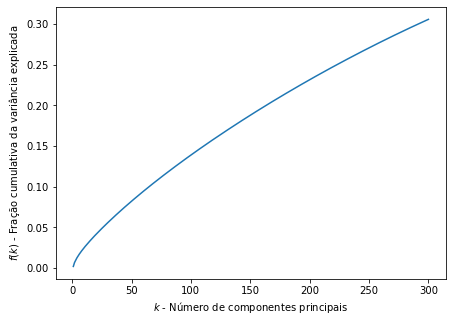

In [17]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, N_COMPONENTS + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

Aplicando o número máximo de componentes principais percebemos que talvez seja preciso um aumento no número de samples uma vez que o valor de componentes principais deve estar no intervalo entre
$$\left[0, \ min(n_{samples} \ , \ n_{features}) \right]$$

# Analise da Quantidade de Grupos

## Elbow Method

In [18]:
from yellowbrick.cluster import KElbowVisualizer
seed = 1
model = KMeans(init='k-means++', random_state = seed)

visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(df_freq_reduced.values)
visualizer.show()


ModuleNotFoundError: No module named 'sklearn.metrics.classification'

# K-means

In [22]:
num_labels = df_mini['genre'].unique().size
print(num_labels)

8


In [23]:
N_CLUSTERS = 4
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
y_pred_k_means = model.fit_predict(df_freq_reduced)
# word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
# cluster_ids = generate_wordclouds(X_svd, X_tfidf, 2, word_positions)
y_pred_k_means

array([1, 1, 0, ..., 3, 3, 0])

<AxesSubplot:>

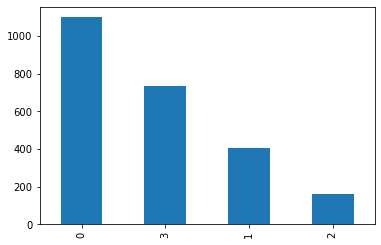

In [24]:
df_mini['pred_k_means'] = y_pred_k_means

df_mini['pred_k_means'].value_counts().plot(kind = 'bar')

# Agrupamento Hierarquico

In [25]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(N_CLUSTERS, linkage = 'ward')
y_pred_ah = model.fit_predict(df_freq_reduced)
y_pred_ah

array([0, 0, 0, ..., 2, 0, 0], dtype=int64)

<AxesSubplot:>

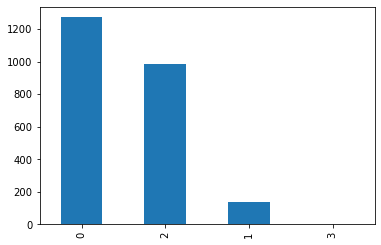

In [26]:
df_mini['y_pred_ah'] = y_pred_ah

df_mini['y_pred_ah'].value_counts().plot(kind = 'bar')

# Agrupamento Espectral

In [27]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters = N_CLUSTERS, affinity = 'nearest_neighbors', n_neighbors = 10)
y_pred_sp = model.fit_predict(df_freq_reduced)
y_pred_sp

array([1, 1, 1, ..., 1, 1, 1])

<AxesSubplot:>

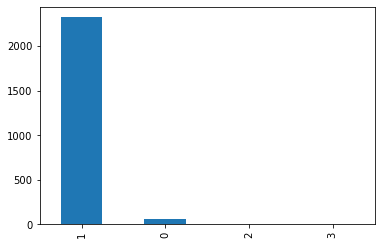

In [28]:
df_mini['y_pred_sp'] = y_pred_sp

df_mini['y_pred_sp'].value_counts().plot(kind = 'bar')

# Evaluate our model

[Text(0.5, 0, 'Cluster Number')]

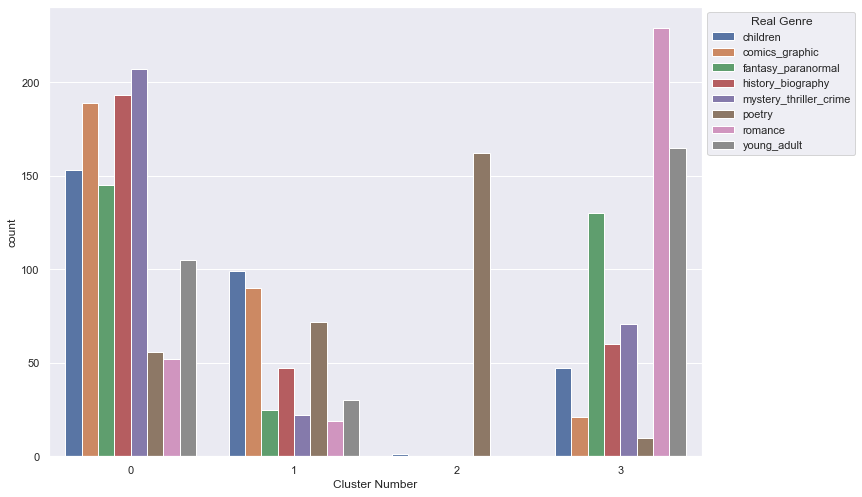

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.countplot(data=df_mini, x='pred_k_means', hue='genre')
p.legend(title='Real Genre', bbox_to_anchor=(1, 1), loc='upper left')
p.set(xlabel='Cluster Number')

# Cross-validation